/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



MSE  (z-scaled RPM)
ARIMA static   : 1.4082
ARIMAX rolling : 0.0015
LSTM           : 0.0029


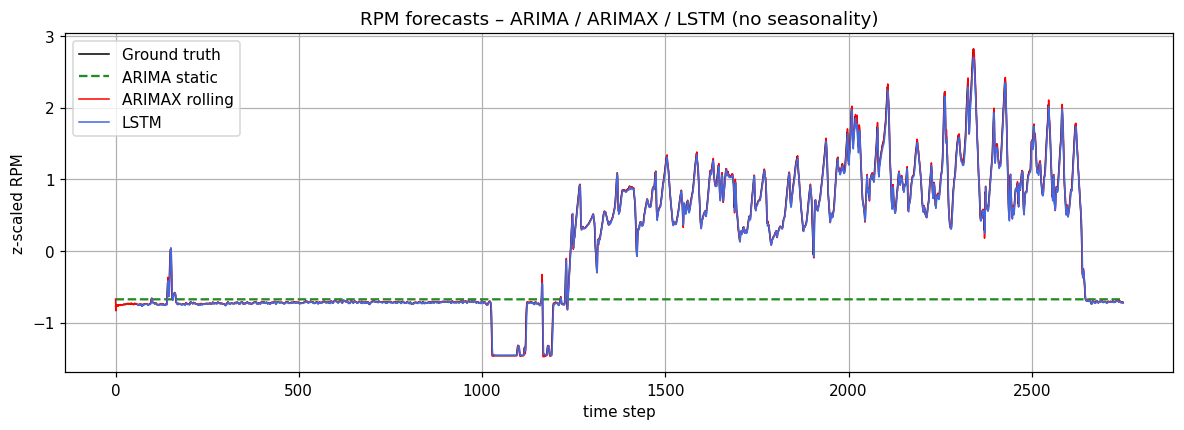

In [ ]:
#─────────────────────────────────────────
# 0) INSTALL & IMPORTS
!pip install --quiet numpy pandas matplotlib statsmodels scikit-learn tensorflow scipy

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
plt.rcParams['figure.dpi']=110
pd.options.mode.chained_assignment=None

#─────────────────────────────────────────
# 1) FILE PATHS (ανέβασε τα αρχεία σου)
BIG1="2025-02-07_12.48.46.csv"
BIG2="2025-02-06_12.29.21.csv"
TEST="2025-02-07_12.39.15.csv"

#─────────────────────────────────────────
# 2) LOAD κοινά σήματα από ID 0x520  → [RPM, Thr*, MAP]
def load_vecs(p):
    df=pd.read_csv(p)
    sig=df[df.ID=='0x520'][['Sensor1','Sensor2','Sensor3']].astype(float)
    return sig.to_numpy()

train_raw=np.vstack([load_vecs(BIG1),load_vecs(BIG2)])
test_raw =load_vecs(TEST)

#─────────────────────────────────────────
# 3) FAST-CLEAN  (outlier-cut, smooth, down-sample)
TRIM=100_000; SMOOTH=20; DS=8
def clean(arr):
    if len(arr)>TRIM: arr=arr[-TRIM:]
    m=np.abs(zscore(arr[:,0],nan_policy='omit'))<3
    arr=uniform_filter1d(arr[m],size=SMOOTH,axis=0)[::DS]
    return arr
train_ds,test_ds=clean(train_raw),clean(test_raw)

# συμπλήρωσε NaN (λείπει throttle σε 2 αρχεία)
for c in (1,2):
    med=np.nanmedian(train_ds[:,c])
    train_ds[np.isnan(train_ds[:,c]),c]=med
    test_ds [np.isnan(test_ds [:,c]),c]=med

rpm_tr,rpm_te = train_ds[:,0],test_ds[:,0]
exo_tr,exo_te = train_ds[:,1:],test_ds[:,1:]      # Thr,MAP

#─────────────────────────────────────────
# 4) SCALERS
scY = StandardScaler(); rpm_tr_sc=scY.fit_transform(rpm_tr[:,None]).ravel()
rpm_te_sc=scY.transform(rpm_te[:,None]).ravel()
scX = StandardScaler();  exo_tr_sc=scX.fit_transform(exo_tr); exo_te_sc=scX.transform(exo_te)

# exogenous + lag-1 για ARIMAX
def add_lag(X):
    lag=np.vstack([np.zeros((1,X.shape[1])),X[:-1]])
    return np.hstack([X,lag])
exo_tr_lag,exo_te_lag=add_lag(exo_tr_sc),add_lag(exo_te_sc)

#─────────────────────────────────────────
# 5) ARIMA static
order=(2,1,2)
arima=ARIMA(rpm_tr_sc,order=order).fit()
fc_arima=arima.forecast(len(rpm_te_sc))
mse_arima=mean_squared_error(rpm_te_sc,fc_arima)

#─────────────────────────────────────────
# 6) ARIMAX rolling (online update)
base=SARIMAX(rpm_tr_sc,exog=exo_tr_lag,
             order=(3,1,3),trend='t').fit(disp=False)
fc_roll=np.empty_like(rpm_te_sc)
state=base
for i in range(len(rpm_te_sc)):
    fc_roll[i]=state.forecast(1,exog=exo_te_lag[i:i+1])[0]
    state=state.extend(endog=rpm_te_sc[i:i+1],
                       exog=exo_te_lag[i:i+1])
mse_roll=mean_squared_error(rpm_te_sc,fc_roll)

#─────────────────────────────────────────
# 7) LSTM
W=60                       # παράθυρο
def make_seq(X,y,W):
    Xs,ys=[],[]
    for i in range(len(y)-W):
        Xs.append(X[i:i+W])
        ys.append(y[i+W])
    return np.array(Xs),np.array(ys)

# multivariate features (RPM,Thr,MAP)
feat_tr=np.hstack([rpm_tr_sc[:,None],exo_tr_sc])
feat_te=np.hstack([rpm_te_sc[:,None],exo_te_sc])

Xtr,ytr=make_seq(feat_tr,rpm_tr_sc,W)
Xts,yts=make_seq(feat_te,rpm_te_sc,W)

model=Sequential([LSTM(64,input_shape=(W,3)),Dense(1)])
model.compile(optimizer=Adam(1e-3),loss='mse')
model.fit(Xtr,ytr,epochs=10,batch_size=128,verbose=0)

fc_lstm=model.predict(Xts,verbose=0).ravel()
mse_lstm=mean_squared_error(yts,fc_lstm)

#─────────────────────────────────────────
# 8) PRINT METRICS
print("\nMSE  (z-scaled RPM)")
print(f"ARIMA static   : {mse_arima :.4f}")
print(f"ARIMAX rolling : {mse_roll  :.4f}")
print(f"LSTM           : {mse_lstm  :.4f}")

#─────────────────────────────────────────
# 9) PLOT  (όλα ευδιάκριτα)
plt.figure(figsize=(13,4))
t=np.arange(len(rpm_te_sc))
plt.plot(t,rpm_te_sc,label='Ground truth',color='black',lw=1)
plt.plot(t,fc_arima ,label='ARIMA static',color='forestgreen',ls='--')
plt.plot(t,fc_roll  ,label='ARIMAX rolling',color='red',lw=1)
plt.plot(t[W:],fc_lstm,label='LSTM',color='royalblue',lw=1)
plt.title('RPM forecasts – ARIMA / ARIMAX / LSTM (no seasonality)')
plt.xlabel('time step'); plt.ylabel('z-scaled RPM')
plt.legend(); plt.grid(); plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


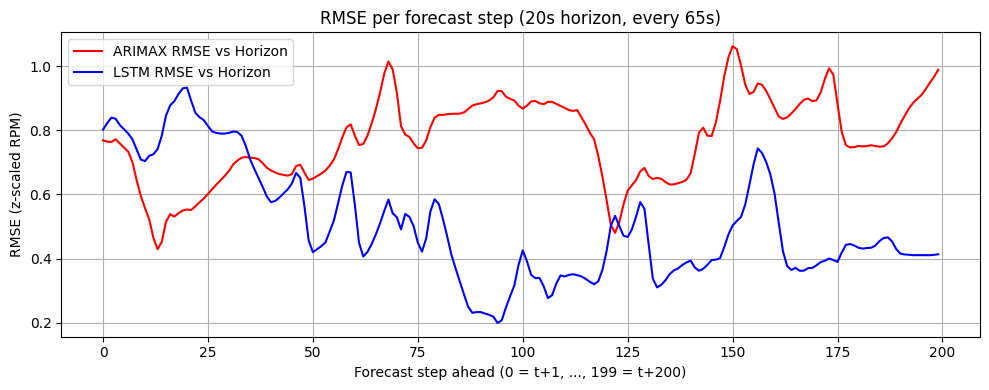

In [7]:
!pip install -q numpy pandas matplotlib scipy scikit-learn statsmodels

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam


# Rolling 20s ahead forecast κάθε 65s (sliding forecast)
H = 200         # forecast horizon: 200 βήματα (~20s @10Hz)
step = 650      # μετακινούμαστε κάθε 650 βήματα (~65s @10Hz)

BIG1  = "2025-02-07_12.48.46.csv"
BIG2  = "2025-02-06_12.29.21.csv"
TEST  = "2025-02-07_12.39.15.csv"

#─────────────────────────────────────
# 4) Φόρτωση ΚΟΙΝΩΝ σημάτων με βάση τα CAN IDs

def load_common_signals(path):
    df = pd.read_csv(path)
    df_520 = df[df.ID == '0x520']
    df_521 = df[df.ID == '0x521']
    df_527 = df[df.ID == '0x527']

    out = pd.DataFrame()
    out['RPM'] = df_520['Sensor1'].astype(float).reset_index(drop=True)
    out['MAP'] = df_520['Sensor3'].astype(float).reset_index(drop=True)
    out['Lambda Actual'] = df_520['Sensor4'].astype(float).reset_index(drop=True)
    out['Sensor 1'] = df_521['Sensor1'].astype(float).reset_index(drop=True)
    out['Sensor 2'] = df_521['Sensor2'].astype(float).reset_index(drop=True)
    out['Lambda A'] = df_521['Sensor3'].astype(float).reset_index(drop=True)
    out['Ignition Angle'] = df_521['Sensor2'].astype(float).reset_index(drop=True)
    out['Lambda Target'] = df_527['Sensor1'].astype(float).reset_index(drop=True)
    out['Potentiometer 1'] = df['Sensor1'].astype(float).reset_index(drop=True)
    out['Potentiometer 2'] = df['Sensor2'].astype(float).reset_index(drop=True)
    return out.dropna()

#─────────────────────────────────────
# 5) Load & clean
RAW_TRAIN = pd.concat([load_common_signals(BIG1), load_common_signals(BIG2)])
RAW_TEST  = load_common_signals(TEST)

TRIM, SMOOTH, DS = 100_000, 20, 8

def clean(arr):
    if len(arr) > TRIM: arr = arr[-TRIM:]
    mask = np.abs(zscore(arr[:,0], nan_policy='omit')) < 3
    arr = uniform_filter1d(arr[mask], size=SMOOTH, axis=0)[::DS]
    return arr

train_ds = clean(RAW_TRAIN.to_numpy())
test_ds  = clean(RAW_TEST.to_numpy())

#─────────────────────────────────────
# 6) Split σε target (RPM) και exogenous
cols = RAW_TRAIN.columns.tolist()
idx_rpm = cols.index('RPM')
feature_indices = [i for i in range(len(cols)) if i != idx_rpm]
X_tr = train_ds[:, feature_indices]
X_te = test_ds[:, feature_indices]
y_tr = train_ds[:, idx_rpm]
y_te = test_ds[:, idx_rpm]

#─────────────────────────────────────
# 7) Scaling
scX, scY = StandardScaler(), StandardScaler()
Xtr_sc, Xte_sc = scX.fit_transform(X_tr), scX.transform(X_te)
ytr_sc, yte_sc = scY.fit_transform(y_tr[:,None]).ravel(), scY.transform(y_te[:,None]).ravel()

#─────────────────────────────────────
# 8) Lag και trend
trend_tr = np.arange(len(Xtr_sc)).reshape(-1,1)
trend_te = np.arange(len(Xte_sc)).reshape(-1,1)
lag1_tr = np.vstack([np.zeros((1, Xtr_sc.shape[1])), Xtr_sc[:-1]])
lag1_te = np.vstack([np.zeros((1, Xte_sc.shape[1])), Xte_sc[:-1]])
exo_tr = np.hstack([Xtr_sc, lag1_tr, trend_tr])
exo_te = np.hstack([Xte_sc, lag1_te, trend_te])




# --- ARIMAX ---
arimax_model = SARIMAX(ytr_sc, exog=exo_tr, order=(3, 1, 3), trend='t').fit(disp=False)
rolling_preds_arimax = []
rolling_truth_arimax = []
state = arimax_model

for t in range(0, len(exo_te) - H, step):
    x_window = exo_te[t:t+H]
    y_window = yte_sc[t:t+H]
    y_forecast = state.forecast(steps=H, exog=x_window)
    rolling_preds_arimax.append(y_forecast)
    rolling_truth_arimax.append(y_window)
    state = state.extend(endog=y_window, exog=x_window)

# --- LSTM ---
W = 60
feat_tr = np.hstack([ytr_sc.reshape(-1, 1), Xtr_sc])
X_seq = np.array([feat_tr[i:i+W] for i in range(len(ytr_sc)-W)])
y_seq = np.array([ytr_sc[i+W] for i in range(len(ytr_sc)-W)])

lstm = Sequential([LSTM(64, input_shape=(W, feat_tr.shape[1])), Dense(1)])
lstm.compile(optimizer=Adam(1e-3), loss='mse')
lstm.fit(X_seq, y_seq, epochs=10, batch_size=128, verbose=0)

rolling_preds_lstm = []
rolling_truth_lstm = []

for t in range(0, len(Xte_sc) - H, step):
    history = list(feat_tr[-W:].copy())
    preds = []
    for i in range(H):
        x_input = np.array(history[-W:]).reshape(1, W, -1)
        yhat = lstm.predict(x_input, verbose=0).ravel()[0]
        preds.append(yhat)
        exo_next = Xte_sc[t + i]
        history.append(np.hstack([yhat, exo_next]))
    rolling_preds_lstm.append(np.array(preds))
    rolling_truth_lstm.append(yte_sc[t:t+H])

# --- Evaluation ---
rolling_preds_arimax = np.array(rolling_preds_arimax)
rolling_truth_arimax = np.array(rolling_truth_arimax)
rolling_preds_lstm = np.array(rolling_preds_lstm)
rolling_truth_lstm = np.array(rolling_truth_lstm)

rmse_arimax = np.sqrt(np.mean((rolling_preds_arimax - rolling_truth_arimax)**2, axis=0))
rmse_lstm = np.sqrt(np.mean((rolling_preds_lstm - rolling_truth_lstm)**2, axis=0))

# --- Plot RMSE per forecast step ---
plt.figure(figsize=(10,4))
plt.plot(rmse_arimax, label='ARIMAX RMSE vs Horizon', color='red')
plt.plot(rmse_lstm, label='LSTM RMSE vs Horizon', color='blue')
plt.title('RMSE per forecast step (20s horizon, every 65s)')
plt.xlabel('Forecast step ahead (0 = t+1, ..., 199 = t+200)')
plt.ylabel('RMSE (z-scaled RPM)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


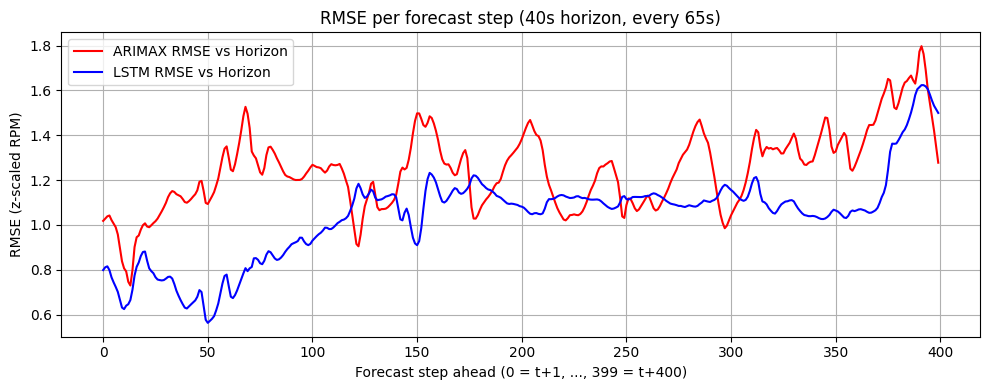

In [8]:
# Rolling 40s ahead forecast κάθε 65s (sliding forecast)
H = 400         # forecast horizon: 400 βήματα (~40s @10Hz)
step = 650      # μετακινούμαστε κάθε 650 βήματα (~65s @10Hz)


# --- ARIMAX ---
arimax_model = SARIMAX(ytr_sc, exog=exo_tr, order=(3, 1, 3), trend='t').fit(disp=False)
rolling_preds_arimax = []
rolling_truth_arimax = []
state = arimax_model

for t in range(0, len(exo_te) - H, step):
    x_window = exo_te[t:t+H]
    y_window = yte_sc[t:t+H]
    y_forecast = state.forecast(steps=H, exog=x_window)
    rolling_preds_arimax.append(y_forecast)
    rolling_truth_arimax.append(y_window)
    state = state.extend(endog=y_window, exog=x_window)

# --- LSTM ---
W = 60
feat_tr = np.hstack([ytr_sc.reshape(-1, 1), Xtr_sc])
X_seq = np.array([feat_tr[i:i+W] for i in range(len(ytr_sc)-W)])
y_seq = np.array([ytr_sc[i+W] for i in range(len(ytr_sc)-W)])

lstm = Sequential([LSTM(64, input_shape=(W, feat_tr.shape[1])), Dense(1)])
lstm.compile(optimizer=Adam(1e-3), loss='mse')
lstm.fit(X_seq, y_seq, epochs=10, batch_size=128, verbose=0)

rolling_preds_lstm = []
rolling_truth_lstm = []

for t in range(0, len(Xte_sc) - H, step):
    history = list(feat_tr[-W:].copy())
    preds = []
    for i in range(H):
        x_input = np.array(history[-W:]).reshape(1, W, -1)
        yhat = lstm.predict(x_input, verbose=0).ravel()[0]
        preds.append(yhat)
        exo_next = Xte_sc[t + i]
        history.append(np.hstack([yhat, exo_next]))
    rolling_preds_lstm.append(np.array(preds))
    rolling_truth_lstm.append(yte_sc[t:t+H])

# --- Evaluation ---
rolling_preds_arimax = np.array(rolling_preds_arimax)
rolling_truth_arimax = np.array(rolling_truth_arimax)
rolling_preds_lstm = np.array(rolling_preds_lstm)
rolling_truth_lstm = np.array(rolling_truth_lstm)

rmse_arimax = np.sqrt(np.mean((rolling_preds_arimax - rolling_truth_arimax)**2, axis=0))
rmse_lstm = np.sqrt(np.mean((rolling_preds_lstm - rolling_truth_lstm)**2, axis=0))

# --- Plot RMSE per forecast step ---
plt.figure(figsize=(10,4))
plt.plot(rmse_arimax, label='ARIMAX RMSE vs Horizon', color='red')
plt.plot(rmse_lstm, label='LSTM RMSE vs Horizon', color='blue')
plt.title('RMSE per forecast step (40s horizon, every 65s)')
plt.xlabel('Forecast step ahead (0 = t+1, ..., 399 = t+400)')
plt.ylabel('RMSE (z-scaled RPM)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


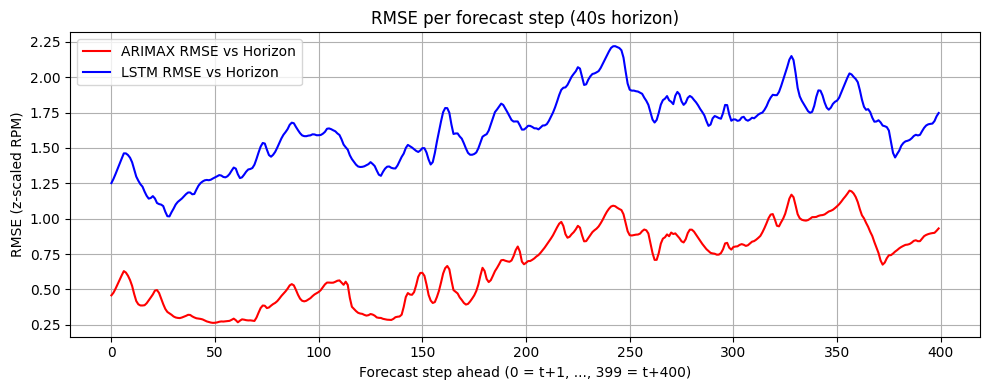

In [9]:
# Rolling 40s ahead forecast κάθε 35s (sliding forecast)
H = 400         # forecast horizon: 400 βήματα (~40s @10Hz)
step = 350      # μετακινούμαστε κάθε 350 βήματα (~35s @10Hz)

# --- ARIMAX ---
arimax_model = SARIMAX(ytr_sc, exog=exo_tr, order=(3, 1, 3), trend='t').fit(disp=False)
rolling_preds_arimax = []
rolling_truth_arimax = []
state = arimax_model

for t in range(0, len(exo_te) - H, step):
    x_window = exo_te[t:t+H]
    y_window = yte_sc[t:t+H]
    y_forecast = state.forecast(steps=H, exog=x_window)
    rolling_preds_arimax.append(y_forecast)
    rolling_truth_arimax.append(y_window)
    state = state.extend(endog=y_window, exog=x_window)

# --- LSTM ---
W = 60
feat_tr = np.hstack([ytr_sc.reshape(-1, 1), Xtr_sc])
X_seq = np.array([feat_tr[i:i+W] for i in range(len(ytr_sc)-W)])
y_seq = np.array([ytr_sc[i+W] for i in range(len(ytr_sc)-W)])

lstm = Sequential([LSTM(64, input_shape=(W, feat_tr.shape[1])), Dense(1)])
lstm.compile(optimizer=Adam(1e-3), loss='mse')
lstm.fit(X_seq, y_seq, epochs=10, batch_size=128, verbose=0)

rolling_preds_lstm = []
rolling_truth_lstm = []

for t in range(0, len(Xte_sc) - H, step):
    history = list(feat_tr[-W:].copy())
    preds = []
    for i in range(H):
        x_input = np.array(history[-W:]).reshape(1, W, -1)
        yhat = lstm.predict(x_input, verbose=0).ravel()[0]
        preds.append(yhat)
        exo_next = Xte_sc[t + i]
        history.append(np.hstack([yhat, exo_next]))
    rolling_preds_lstm.append(np.array(preds))
    rolling_truth_lstm.append(yte_sc[t:t+H])

# --- Evaluation ---
rolling_preds_arimax = np.array(rolling_preds_arimax)
rolling_truth_arimax = np.array(rolling_truth_arimax)
rolling_preds_lstm = np.array(rolling_preds_lstm)
rolling_truth_lstm = np.array(rolling_truth_lstm)

rmse_arimax = np.sqrt(np.mean((rolling_preds_arimax - rolling_truth_arimax)**2, axis=0))
rmse_lstm = np.sqrt(np.mean((rolling_preds_lstm - rolling_truth_lstm)**2, axis=0))

# --- Plot RMSE per forecast step ---
plt.figure(figsize=(10,4))
plt.plot(rmse_arimax, label='ARIMAX RMSE vs Horizon', color='red')
plt.plot(rmse_lstm, label='LSTM RMSE vs Horizon', color='blue')
plt.title('RMSE per forecast step (40s horizon)')
plt.xlabel('Forecast step ahead (0 = t+1, ..., 399 = t+400)')
plt.ylabel('RMSE (z-scaled RPM)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


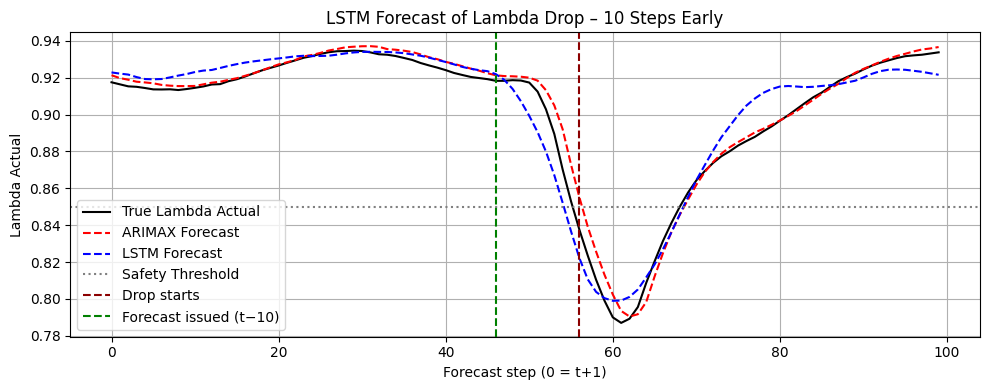

In [12]:
# !pip install -q pandas numpy matplotlib scipy scikit-learn statsmodels tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# 1. Load your test CSV
df = pd.read_csv("2025-02-07_12.39.15.csv")

# 2. Select CAN ID 0x520/521/527 and extract relevant signals
df_520 = df[df.ID == '0x520']
df_521 = df[df.ID == '0x521']
df_527 = df[df.ID == '0x527']

data = pd.DataFrame({
    'RPM': df_520['Sensor1'].astype(float).reset_index(drop=True),
    'MAP': df_520['Sensor3'].astype(float).reset_index(drop=True),
    'Lambda Actual': df_520['Sensor4'].astype(float).reset_index(drop=True),
    'Sensor 1': df_521['Sensor1'].astype(float).reset_index(drop=True),
    'Sensor 2': df_521['Sensor2'].astype(float).reset_index(drop=True),
    'Lambda A': df_521['Sensor3'].astype(float).reset_index(drop=True),
    'Ignition Angle': df_521['Sensor2'].astype(float).reset_index(drop=True),
    'Lambda Target': df_527['Sensor1'].astype(float).reset_index(drop=True),
})

data.dropna(inplace=True)

# 3. Extract 300 samples around Lambda < 0.85
event_idx = data[data['Lambda Actual'] < 0.85].index[0]
segment = data.iloc[max(0, event_idx - 200):event_idx + 100]

def clean(arr):
    mask = np.abs(zscore(arr[:, 2], nan_policy='omit')) < 3
    return uniform_filter1d(arr[mask], size=20, axis=0)[::2]

seg_arr = clean(segment.to_numpy())

# 4. Separate target (Lambda Actual) and inputs
target_idx = 2
X = np.delete(seg_arr, target_idx, axis=1)
y = seg_arr[:, target_idx]

scX, scY = StandardScaler(), StandardScaler()
Xsc = scX.fit_transform(X)
ysc = scY.fit_transform(y.reshape(-1, 1)).ravel()

# ------------------ ARIMAX ------------------
trend = np.arange(len(Xsc)).reshape(-1, 1)
lag1 = np.vstack([np.zeros((1, Xsc.shape[1])), Xsc[:-1]])
exo = np.hstack([Xsc, lag1, trend])
H = 100  # 10s horizon

arimax_model = SARIMAX(ysc, exog=exo, order=(3,1,3), trend='t').fit(disp=False)
fc_arimax = []
state = arimax_model
for t in range(len(ysc) - H):
    xt = exo[t:t+H]
    ypred = state.forecast(steps=H, exog=xt)
    fc_arimax.append(ypred)
    state = state.extend(endog=ysc[t:t+H], exog=xt)

# ------------------ LSTM ------------------
W = 60
feat = np.hstack([ysc.reshape(-1, 1), Xsc])
X_lstm = np.array([feat[i:i+W] for i in range(len(ysc)-W)])
y_lstm = np.array([ysc[i+W] for i in range(len(ysc)-W)])

model = Sequential([LSTM(64, input_shape=(W, feat.shape[1])), Dense(1)])
model.compile(optimizer=Adam(1e-3), loss='mse')
model.fit(X_lstm, y_lstm, epochs=10, batch_size=32, verbose=0)

# Rolling forecast with LSTM
lstm_preds = []
history = list(feat[-W:].copy())
for i in range(H):
    xi = np.array(history[-W:]).reshape(1, W, -1)
    yhat = model.predict(xi, verbose=0).ravel()[0]
    lstm_preds.append(yhat)
    exo_next = Xsc[-H + i]
    history.append(np.hstack([yhat, exo_next]))

# Inverse transform for plot
true_lambda = scY.inverse_transform(ysc[-H:].reshape(-1,1)).ravel()
arimax_pred = scY.inverse_transform(fc_arimax[-1].reshape(-1,1)).ravel()
lstm_pred = scY.inverse_transform(np.array(lstm_preds).reshape(-1,1)).ravel()

# ------------------ Plot with Prediction Lead ------------------
drop_start = np.argmax(true_lambda < 0.85)
anticipation = max(0, drop_start - 10)

plt.figure(figsize=(10, 4))
plt.plot(true_lambda, label="True Lambda Actual", color='black')
plt.plot(arimax_pred, label="ARIMAX Forecast", linestyle='--', color='red')
plt.plot(lstm_pred, label="LSTM Forecast", linestyle='--', color='blue')
plt.axhline(0.85, linestyle=':', color='gray', label='Safety Threshold')
plt.axvline(drop_start, linestyle='--', color='darkred', label='Drop starts')
plt.axvline(anticipation, linestyle='--', color='green', label='Forecast issued (t−10)')
plt.xlabel("Forecast step (0 = t+1)")
plt.ylabel("Lambda Actual")
plt.title("LSTM Forecast of Lambda Drop – 10 Steps Early")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("lambda_forecast_10s_ahead.png", dpi=300)
plt.show()
